# SVM Model Optimization: Learning Curves, Validation Curves, and Hyperparameter Tuning
This notebook demonstrates the steps involved in optimizing an SVM classifier, which includes the plotting of learning and validation curves, and fine-tuning hyperparameters using GridSearchCV. The process aims to find the best parameters to improve performance metrics on a test dataset.

In [1]:
import utils
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from ucimlrepo import fetch_ucirepo

Let's download the AIDS Clinical Trials Group Study 175 dataset from the UCI ML repository using _fetch_ucirepo_.

The details on the dataset are available in the link:
https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175

In [2]:
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)
X = aids_clinical_trials_group_study_175.data.features
y = aids_clinical_trials_group_study_175.data.targets.squeeze()

Check the distribution of the labels

In [3]:
np.bincount(y)

array([1618,  521])

As shown above, the dataset is imbalanced. To account for class imbalance, the **weighted F1 score** will be used as the evaluation metric.

In [4]:
random_state = 42
scoring = 'f1_weighted'

The dataset is split into training and testing sets with stratification to maintain the same class distribution as the original dataset. In addition, stratified k-fold cross-validation is configured to ensure that each fold maintains the same class distribution.

In [5]:
# Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

# Set up CV with stratification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

Set up a pipeline with a standard scaler and an SVM model with polynomial kernel and fit it to the training data

In [6]:
svm_pipe = make_pipeline(StandardScaler(), SVC(kernel='poly')).fit(X_train, y_train)

### Learning Curve before Hyperparameter Tuning

Let's plot a learning curve for SVM with polynomial kernel without hyperparameter tuning.

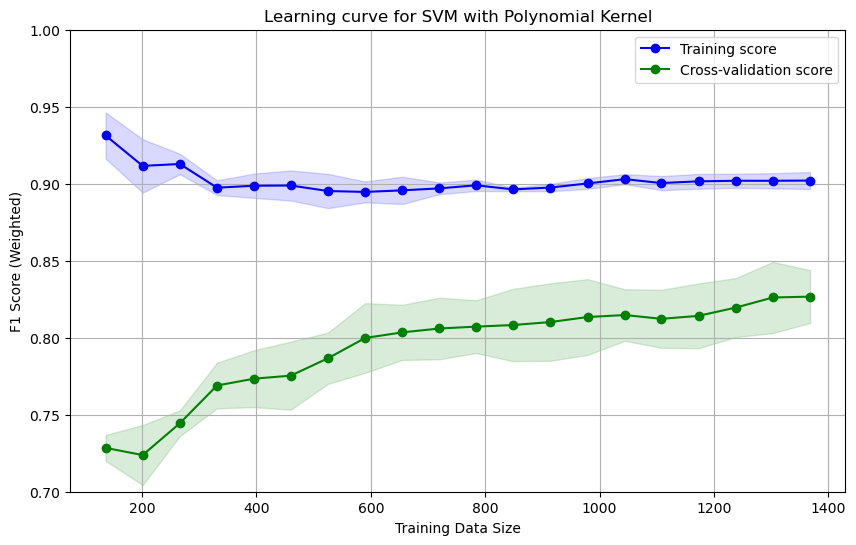

In [7]:
utils.plot_learning_curve(svm_pipe, X_train, y_train, cv, scoring, ylabel='F1 Score (Weighted)', title='Learning curve for SVM with Polynomial Kernel', ylim=(0.7, 1.0), show=True)

The above learning curve shows that as more data is added, the cross-validation score increases and stabillies around 0.82. A large gap between the training and cross-validation scores indicates overfitting.

### Initial Evaluation before Optimization
Let's test the model on a test set and generate a classification report for the SVM model before hyperparameter tuning.

In [8]:
utils.generate_classification_report(svm_pipe, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       324
           1       0.73      0.52      0.61       104

    accuracy                           0.84       428
   macro avg       0.79      0.73      0.75       428
weighted avg       0.83      0.84      0.83       428



As shown above, the weighted F1 score on a test set is 0.83.

### Validation Curves
Let's generate some validation curves with different parameters.

Validation Curve with C

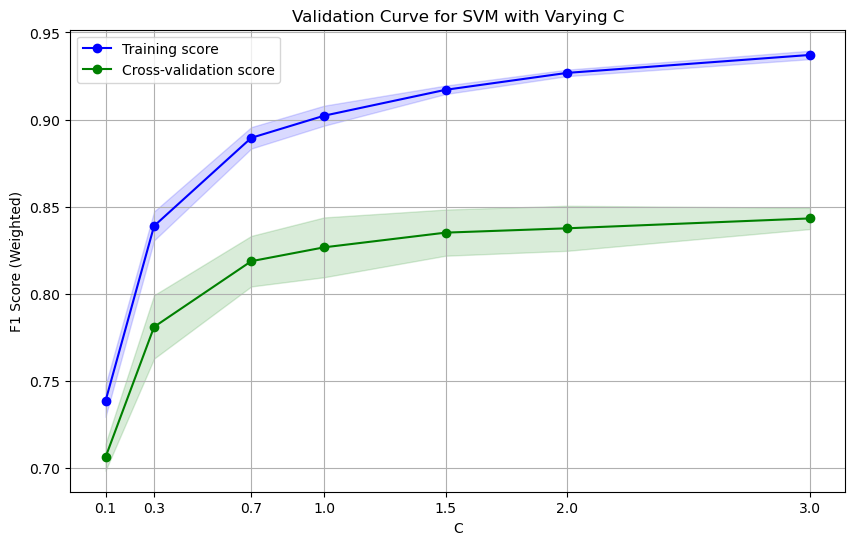

In [9]:
utils.plot_validation_curve(svm_pipe, X_train, y_train, param_name='svc__C', param_range=[0.1, 0.3, 0.7, 1.0, 1.5, 2.0, 3.0], cv=cv, scoring=scoring, title='Validation Curve for SVM with Varying C', xlabel='C', ylabel='F1 Score (Weighted)', show=True)

Validation Curve with Degree

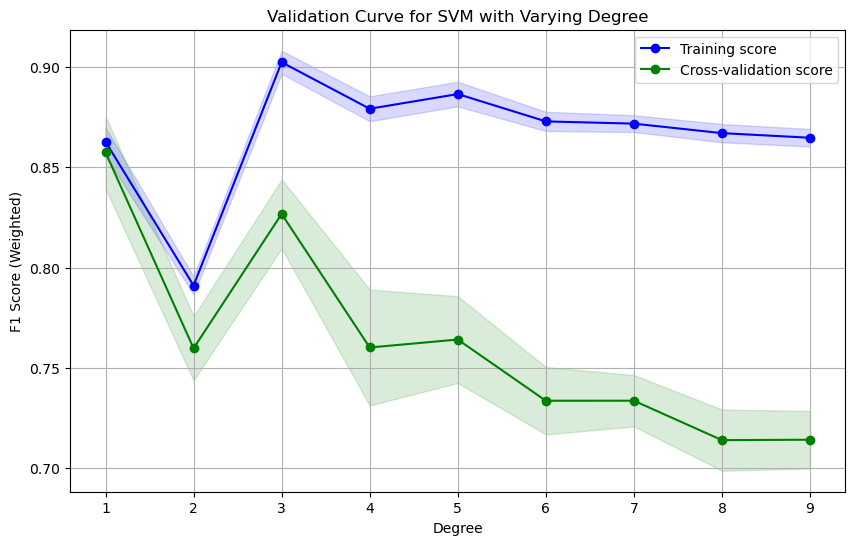

In [10]:
utils.plot_validation_curve(svm_pipe, X_train, y_train, param_name='svc__degree', param_range=np.arange(1, 10), cv=cv, scoring=scoring, title='Validation Curve for SVM with Varying Degree', xlabel='Degree', ylabel='F1 Score (Weighted)', show=True)

Validation Curve with Coefficient

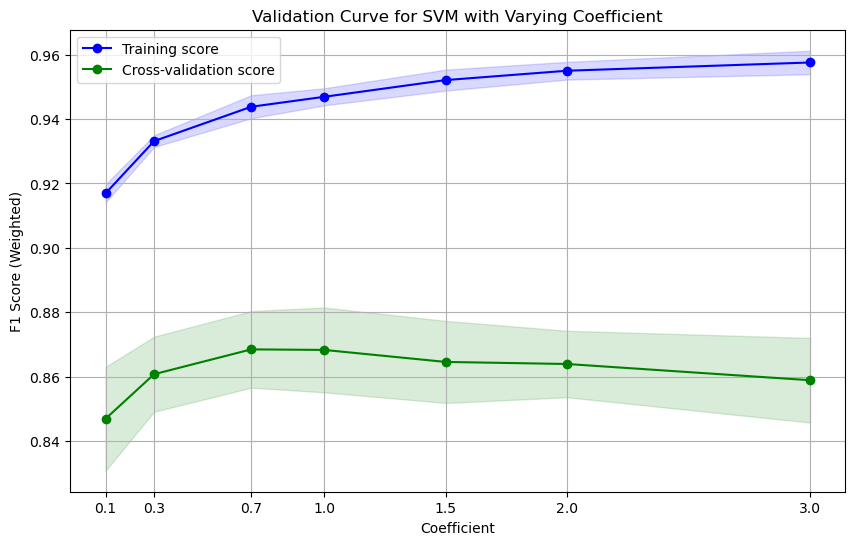

In [11]:
utils.plot_validation_curve(svm_pipe, X_train, y_train, param_name='svc__coef0', param_range=[0.1, 0.3, 0.7, 1.0, 1.5, 2.0, 3.0], cv=cv, scoring=scoring, title='Validation Curve for SVM with Varying Coefficient', xlabel='Coefficient', ylabel='F1 Score (Weighted)', show=True)

### Grid Search
Based on insights from the validation curves, Grid search is used with a narrow search space to find the best parameter combination. The parameter grid below focuses on the areas where each parameter significantly impacts performance according to the validation curves.

In [12]:
# Define a parameter grid to search over
param_grid = {
    'svc__C': np.arange(0.5, 2.1, 0.1),
    'svc__coef0': np.arange(0.5, 1.6, 0.1),
    'svc__degree': np.arange(1, 4, 1),
}

# Setup a GridSearchCV object
grid_search = GridSearchCV(svm_pipe, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

# Fit the training data to the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best estimator, which has already been trained on the training set
best_estimator = grid_search.best_estimator_

Let's check the best parameters and best CV score found during the grid search.

In [13]:
print("Best parameters:", grid_search.best_params_)
print("Best CV score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'svc__C': np.float64(0.7), 'svc__coef0': np.float64(0.7), 'svc__degree': np.int64(2)}
Best CV score: 0.88


### Learning Curve after Hyperparameter Tuning

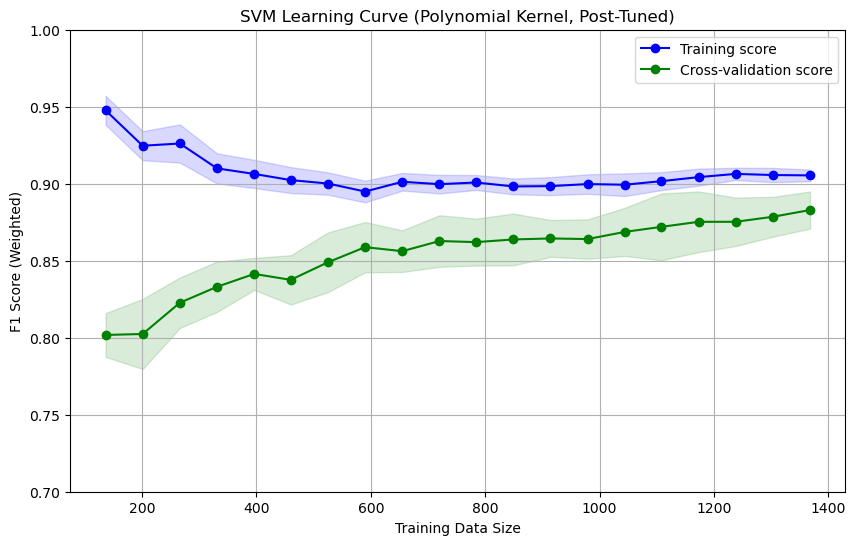

In [14]:
# Learning curve SVM with the tuned parameters
utils.plot_learning_curve(best_estimator, X_train, y_train, cv, scoring, title='SVM Learning Curve (Polynomial Kernel, Post-Tuned)', ylabel='F1 Score (Weighted)', ylim=(0.7, 1.0), show=True)

As shown above, the cross-validation score has improved to approximately 0.88 and shows better generalization than the pre-tuning state. The gap between the training and cross-validation scores has narrowed, significantly reducing overfitting.

### Evaluation after Optimization
The best estimator is evaluated on the test set, and a classification report is generated.

In [15]:
utils.generate_classification_report(best_estimator, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       324
           1       0.83      0.66      0.74       104

    accuracy                           0.89       428
   macro avg       0.86      0.81      0.83       428
weighted avg       0.88      0.89      0.88       428



As shown above, the weighted F1 score improved from 0.83 to 0.88 after optimization. Most notably, the recall for class 1 increased from 0.52 to 0.66, which indicates that the model is now significantly better at identifying true positives for class 1.

### Conclusion
This notebook demonstrated the process of optimizing an SVM classifier with a polynomial kernel. We improved the model's ability to generalize through learning and validation curves and hyperparameter tuning. The post-tuning learning curve showed less overfitting and better model performance. The final evaluation on the test set confirmed the improvements, particularly for the minority class.